In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import nibabel as nib
import os
import random
from pathlib import Path

HGG_path = Path(os.path.expanduser("~/CV_project_MRI/data/MICCAI_BraTS_2019_Data_Training/HGG/"))
LGG_path = Path(os.path.expanduser("~/CV_project_MRI/data/MICCAI_BraTS_2019_Data_Training/LGG/"))

# Dataset exploration

In [ ]:

# Load NIfTI file
img = nib.load(os.path.join(HGG_path, "BraTS19_2013_2_1/BraTS19_2013_2_1_flair.nii"))
data = img.get_fdata()
data.shape



(240, 240, 155)

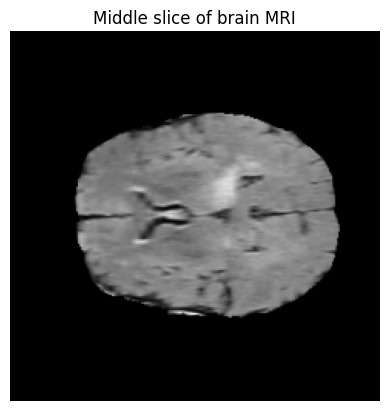

In [ ]:

# Plot a slice
plt.imshow(data[:, :, 80], cmap="gray") # coupe selon z=80 -> faire une video avec toutes les hauteurs? Couper selon les autres axes? 
plt.title("Middle slice of brain MRI")
plt.axis("off")
plt.show()

In [ ]:

imgs = []

# selectionner x patients au hasard
x = 20
patients = [p for p in HGG_path.iterdir() if p.is_dir()]
sampled_patients = random.sample(patients, x)
print(sampled_patients)

# Boucle sur les x patients
for patient in sampled_patients:
    print(patient.name)
    T1 = nib.load(f"{HGG_path}/{patient.name}/{patient.name}_t1.nii")
    T1CE = nib.load(f"{HGG_path}/{patient.name}/{patient.name}_t1ce.nii")
    T2 = nib.load(f"{HGG_path}/{patient.name}/{patient.name}_t2.nii")
    FLAIR = nib.load(f"{HGG_path}/{patient.name}/{patient.name}_flair.nii")
    SEG = nib.load(f"{HGG_path}/{patient.name}/{patient.name}_seg.nii")
    imgs.append([T1, T1CE, T2, FLAIR, SEG])


# Plot a slice
fig, axes = plt.subplots(x, 5, figsize=(20, x*4))  # x rows, 5 columns

for i, patient in enumerate(imgs):
    for j, img in enumerate(patient):
        data = img.get_fdata()
        ax = axes[i, j]
        ax.imshow(data[:, :, 146], cmap="gray")
        ax.set_title(f"Patient {i+1} - Img {j+1}")
        ax.axis("off")


# Pre rocessing
Nous avons des images en 240x240x155 et nous souhaitons les redimensionner en 240x240x144 (sans alterer les dimensions). \
Nous constatons que sur les grande majorite des images, le cerveau s'arrete a 147 pixels et commence a 3 pixels (sur l'axe z). \
Nous allons donc supprimer les 3 premieres couches ainsi que les 8 dernieres pour supprimer les couches vides et ainsi obtenir des parrallelepipedes de 240x240x144.

In [19]:
data = data[:,:,3:147]
data.shape

(240, 240, 141)

- Appliquer ce filtre sur toutes les images flair et segmentation \
- extraire toutes les images flair/seg redimensionnées dans un dossier sous la forme: \
 dataset_UNET/ \
 | \
 |- X \
 |   |- {patient_ID}_flair.nii  \
 |   |... \
 |- Y \
 |   |- {patient_ID}_seg.nii  \
 |   |... \
 |- label.csv -> (patient_ID, grade) pour realiser la classification \
\
(- Regrouper les deux fichiers csv et ne garder que les colonnes: grade, ID_2019, age, survival, ResectionStatus)\
   -> Les fichiers csv sont ils utiles dans notre cas? Servent-ils uniquement dans un cas ou on souhaite entrainer \
   un model de ML pour faire de la predicitions de cancer ou autre, mais pas dans notre cas de detection de tumeur par computer vision? 
\
Le dossier dataset nous servira de base pour entrainer le model UNET

In [22]:
output_X = Path("~/CV_project_MRI/data/MICCAI_BraTS_2019_Data_Training/dataset_UNET/X").expanduser()
output_Y = Path("~/CV_project_MRI/data/MICCAI_BraTS_2019_Data_Training/dataset_UNET/Y").expanduser()

output_X.mkdir(parents=True, exist_ok=True)
output_Y.mkdir(parents=True, exist_ok=True)

patients_HGG = [p for p in HGG_path.iterdir() if p.is_dir()]
patients_LGG = [p for p in LGG_path.iterdir() if p.is_dir()]

for patient in patients_HGG:
    try:
        flair_path = patient / f"{patient.name}_flair.nii"
        seg_path   = patient / f"{patient.name}_seg.nii"

        # Chargement et crop Z
        flair_data = nib.load(flair_path).get_fdata()[:, :, 3:147]
        seg_data   = nib.load(seg_path).get_fdata()[:, :, 3:147]

        # Sauvegarde des .nii.gz cropped
        flair_img = nib.Nifti1Image(flair_data, affine=np.eye(4))  # ajouter une affine minimale
        seg_img   = nib.Nifti1Image(seg_data, affine=np.eye(4))

        nib.save(flair_img, output_X / f"{patient.name}_flair.nii.gz")
        nib.save(seg_img,   output_Y / f"{patient.name}_seg.nii.gz")

    except Exception as e:
        print(f"Erreur avec {patient.name}: {e}")


In [23]:
for patient in patients_LGG:
    try:
        flair_path = patient / f"{patient.name}_flair.nii"
        seg_path   = patient / f"{patient.name}_seg.nii"

        # Chargement et crop Z
        flair_data = nib.load(flair_path).get_fdata()[:, :, 3:147]
        seg_data   = nib.load(seg_path).get_fdata()[:, :, 3:147]

        # Sauvegarde des .nii.gz cropped
        flair_img = nib.Nifti1Image(flair_data, affine=np.eye(4))  # ajouter une affine minimale
        seg_img   = nib.Nifti1Image(seg_data, affine=np.eye(4))

        nib.save(flair_img, output_X / f"{patient.name}_flair.nii.gz")
        nib.save(seg_img,   output_Y / f"{patient.name}_seg.nii.gz")

    except Exception as e:
        print(f"Erreur avec {patient.name}: {e}")

# Training

### Tensorboard setup

In [ ]:
!tensorboard --logdir "./logs"

# TensorBoard est un objet callback
from tensorflow.keras.callbacks import TensorBoard
import os

EPOCH = 100
BATCH_SIZE = 10
dataset_path = Path("~/CV_project_MRI/data/MICCAI_BraTS_2019_Data_Training/dataset_UNET/").expanduser()

model = create_unet(dataset_path)
tensorboard_callback_unet = TensorBoard(log_dir=os.path.expanduser("~CV_project_MRI/logs/unet"))

model.fit(
    x=X, y=y,
    epochs=EPOCH,
    callbacks=[tensorboard_callback_unet],
    batch_size=BATCH_SIZE
)


### UNET

In [25]:
def create_unet(dataset_path):
    X = nib.load(dataset_path/"X")

### YOLO